# Weighted ECM clustering vs Traditional ECM clustering
## LettersIJL dataset

In [2]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.wecm_new import wecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot, calculate_non_specificity
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from evclust.datasets import load_letters


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


LettersIJL DS: 227 instances, 16 features


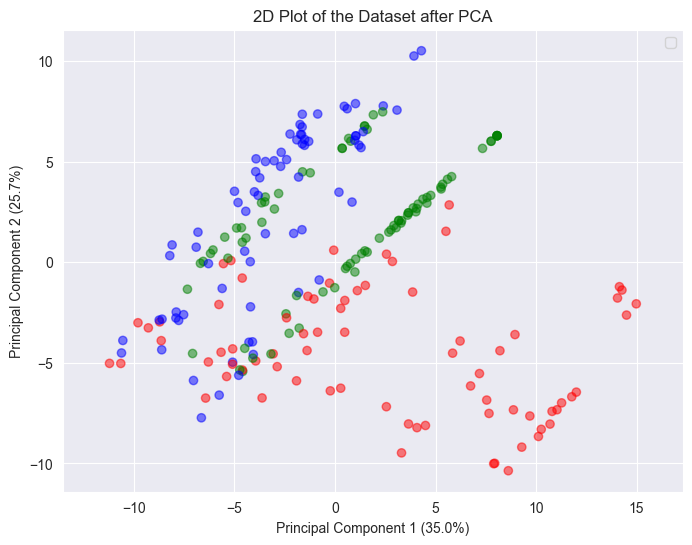

In [3]:
# fetch dataset
df = load_letters()

# data (as pandas dataframes)
y = pd.DataFrame(df.iloc[:, -1])
X = df.iloc[:, :-1]

labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y['class'])

# Scatter matrix plot
# sns.pairplot(df, corner=True, hue="class")

# Perform PCA for dimensionality reduction
value_to_color = {0: 'green', 1: 'blue', 2: 'red'}
colors = [value_to_color[val] for val in numeric_labels]

pca = PCA(n_components=2)  # Reduce to 2 dimensions
data_reduced = pca.fit_transform(X)
variance_percent = np.round(pca.explained_variance_ratio_ * 100, 1)

print(f"LettersIJL DS: {X.shape[0]} instances, {X.shape[1]} features")
# Plot the reduced dataset with different colors for each cluster
plt.figure(figsize=(8, 6))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], alpha=0.5, c=colors)
plt.title('2D Plot of the Dataset after PCA')
plt.xlabel(f"Principal Component 1 ({variance_percent[0]}%)")
plt.ylabel(f"Principal Component 2 ({variance_percent[1]}%)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


## Traditional ECM

[1, 4270.149129366722]
[2, 4162.600481889625]
[3, 4143.910723958547]
[4, 4137.938769105983]
[5, 4135.5027090947015]
[6, 4134.355544578969]
[7, 4133.768014445183]
[8, 4133.45137909443]
[9, 4133.274949958385]
[10, 4133.1742868645615]
[11, 4133.115805074122]
[12, 4133.081328151524]
[13, 4133.060747039157]
[14, 4133.048321870272]
[15, 4133.040739957314]
[16, 4133.036063908818]
[17, 4133.033148022492]
[18, 4133.031308236643]
[19, 4133.030132570628]
[20, 4133.02937087009]
[   0.         4133.02937087 4133.02937087]
[1, 4273.297312811215]
[2, 4162.742906603595]
[3, 4143.879213282375]
[4, 4137.921583003087]
[5, 4135.500144893134]
[6, 4134.35857014382]
[7, 4133.772138346298]
[8, 4133.455005380341]
[9, 4133.277714577072]
[10, 4133.176258098723]
[11, 4133.117160737304]
[12, 4133.082241443914]
[13, 4133.061355178539]
[14, 4133.048724433642]
[15, 4133.041005946731]
[16, 4133.036239874294]
[17, 4133.033264861912]
[18, 4133.031386260326]
[19, 4133.030185058664]
[20, 4133.029406488028]
[1.00000000e+00

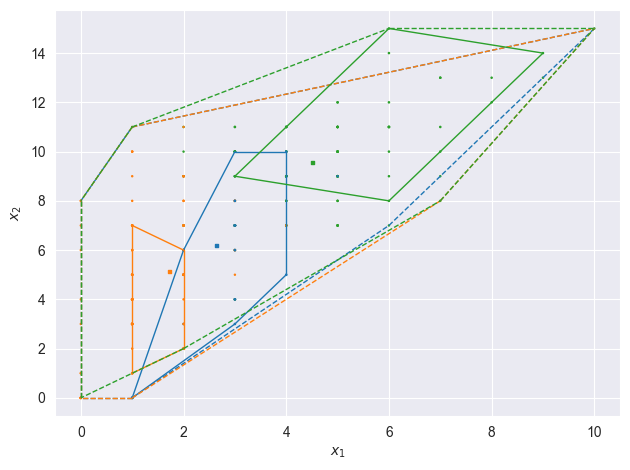

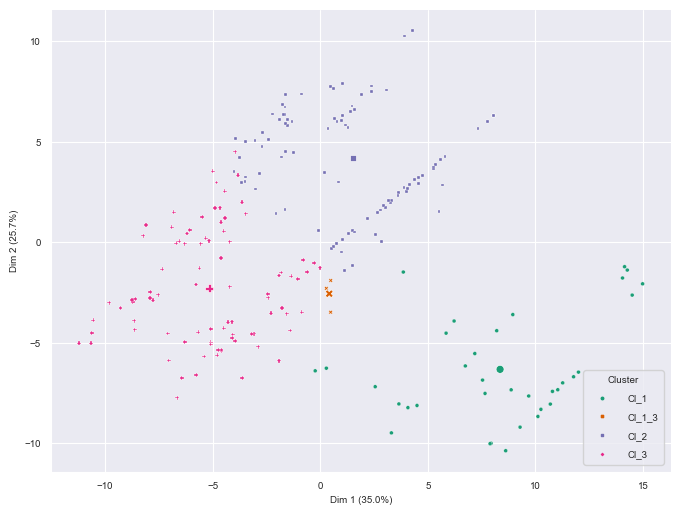

----------Traditional ECM----------
Jbest: 4133.0292559059235
Centers: 
 [[ 2.64088969  6.18957144  3.25610795  4.99341742  1.68279827  3.77793965
   3.34064177  4.32508611  6.18144979  3.22763359  2.17788991  7.05098221
   0.34457489  7.43649552  1.04566339  7.27267455]
 [ 1.72118573  5.13080361  2.43389771  4.06003     1.29438725  8.26505611
   6.3464873   2.48293077  5.73307502 11.05961231  5.27303212  8.7680416
   0.4187892   7.37511739  1.21142987  7.6909935 ]
 [ 4.51059989  9.55505169  5.10801769  7.28993878  3.60567537  8.03103903
   6.18014617  2.9745283   5.53642132 10.46399014  5.44054861  8.74441097
   1.81912268  7.69055385  4.39055028  8.36001169]]
Adjusted Rand Index (ARI): 0.19515340295452677
Maximum Non-specificity value: 2.1648800038703304
Minimum Non-specificity value: 0.5306287315202269
Average Non-specificity value: 1.5208368923383775
Average Normalized Non-specificity value: 0.9595412457054338


In [19]:
# Traditional ECM clustering
model = ecm(x=X, c=3, beta=2, alpha=1, delta=100, ntrials=5)

ev_plot(model, X=X)
ev_pcaplot(data=X, x=model, normalize=False)

# Compute the Adjusted Rand Index (ARI)
true_labels = numeric_labels
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

ari = adjusted_rand_score(true_labels, predicted_labels)
print("----------Traditional ECM----------")
print(f"Jbest: {model['crit']}")
print(f"Centers: \n {model['g']}")

print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate Non-specificity
calculate_non_specificity(model)

## Weighted ECM (WECM)

Initial weights: 
 [[0.23731218 0.00201435 0.00845606 0.00249785 0.08287942 0.00090831
  0.21169361 0.01813973 0.04081386 0.01734401 0.0298898  0.00857061
  0.14971047 0.11276143 0.03839339 0.0386149 ]
 [0.04391228 0.11850017 0.05077942 0.02045962 0.06347784 0.02595456
  0.08516361 0.05943297 0.01756978 0.00248841 0.03147024 0.06915531
  0.02343275 0.03810224 0.12668575 0.22341505]
 [0.04575623 0.00212441 0.13004581 0.04100444 0.01635153 0.0098527
  0.03222102 0.02309984 0.08945624 0.10159646 0.05957063 0.00070901
  0.05253759 0.06376935 0.03617661 0.29572811]]
---------Iteration #1---------
Initial prototypes: 
 [[ 4.59183673  9.53061224  5.3877551   7.32653061  3.80612245  7.62244898
   6.25510204  2.44897959  5.98979592 10.09183673  5.07142857  8.42857143
   1.79591837  7.69387755  4.5         8.21428571]
 [ 2.75        5.84375     3.40625     4.6875      1.53125     2.03125
   2.15625     4.875       6.375       0.96875     0.96875     6.03125
   0.21875     7.40625     0.46875    

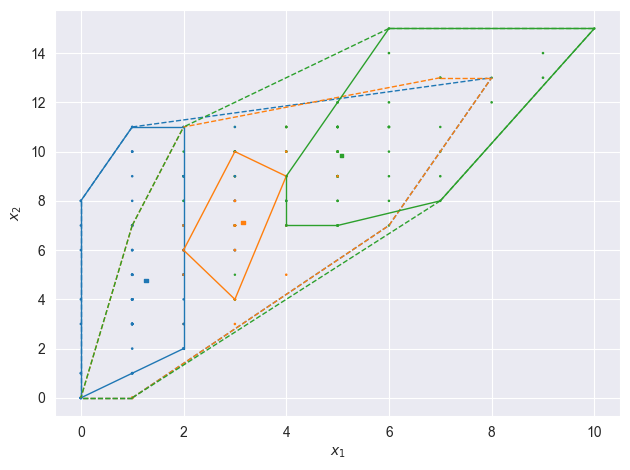

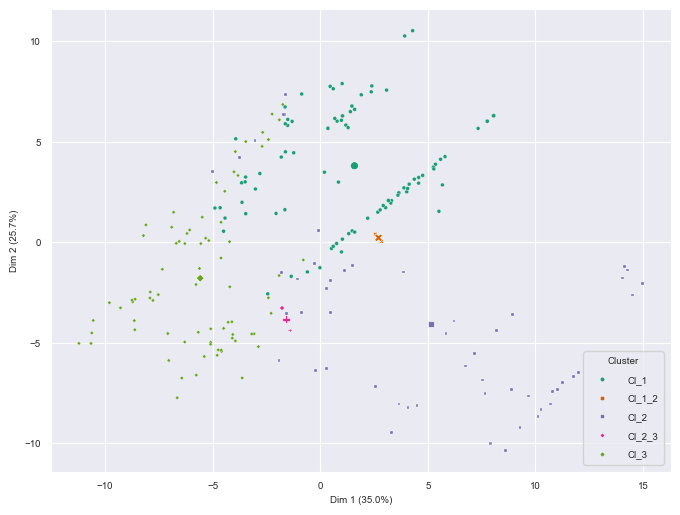

Covariance Matrix 1: [ 1.0137457  10.16129725  2.6112543   5.21520619  0.89411512  2.19222509
  1.41151203  5.08140034  2.56378866  9.21778351  1.02126289  2.10352234
  0.40635739  0.60223368  1.38273196  0.46971649]
Covariance Matrix 2: [ 0.9668175   8.40837104  2.11877828  4.07239819  1.35897436 12.30015083
  1.96191554  4.49886878  2.56410256 17.17043741  0.89102564  4.64705882
  0.53808446  0.77828054  1.34351433  1.47511312]
Covariance Matrix 3: [2.78854479 5.1043956  1.99350649 2.48551449 2.77322677 4.18464868
 5.38145188 6.44438894 2.32251082 8.14785215 2.11738262 6.98851149
 2.33050283 1.43656344 9.50799201 2.2011322 ]


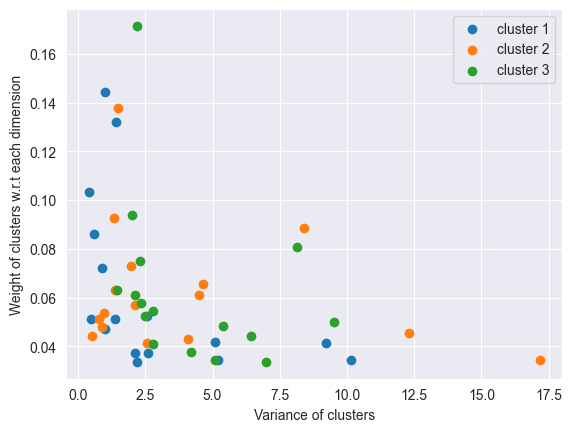

In [18]:
# Feature weighted ECM clustering
W = np.array([
    [0.23731218, 0.00201435, 0.00845606, 0.00249785, 0.08287942, 0.00090831
        , 0.21169361, 0.01813973, 0.04081386, 0.01734401, 0.0298898, 0.00857061
        , 0.14971047, 0.11276143, 0.03839339, 0.0386149],
    [0.04391228, 0.11850017, 0.05077942, 0.02045962, 0.06347784, 0.02595456
        , 0.08516361, 0.05943297, 0.01756978, 0.00248841, 0.03147024, 0.06915531
        , 0.02343275, 0.03810224, 0.12668575, 0.22341505],
    [0.04575623, 0.00212441, 0.13004581, 0.04100444, 0.01635153, 0.0098527
        , 0.03222102, 0.02309984, 0.08945624, 0.10159646, 0.05957063, 0.00070901
        , 0.05253759, 0.06376935, 0.03617661, 0.29572811]
])
c = 3
model = wecm(x=X, c=c, W=W, beta=2, alpha=1, delta=100, epsi=1e-3, ntrials=10)

true_labels = numeric_labels
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

# Compute the Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_labels)
print("----------Weighted ECM----------")
print(f"Jbest: {model['crit']}")
print(f"Centers: \n {model['g']}")
print(f"Final weights: \n{model['W']}")

print(f"Adjusted Rand Index (ARI): {ari} - J value: {model['crit']}")

# Calculate Non-specificity
calculate_non_specificity(model)

# Plots
ev_plot(model, X=X)
ev_pcaplot(data=X, x=model, normalize=False)

W = model['W']
cov_mat1 = np.cov(X[predicted_labels == 0].transpose())
cov_mat2 = np.cov(X[predicted_labels == 1].transpose())
cov_mat3 = np.cov(X[predicted_labels == 2].transpose())
print(f"Covariance Matrix 1: {cov_mat1.diagonal()}")
print(f"Covariance Matrix 2: {cov_mat2.diagonal()}")
print(f"Covariance Matrix 3: {cov_mat3.diagonal()}")

W_COV_1 = pd.DataFrame({'y': W[0, :], 'x': cov_mat1.diagonal()})
W_COV_1.sort_values('x', inplace=True)
W_COV_2 = pd.DataFrame({'y': W[1, :], 'x': cov_mat2.diagonal()})
W_COV_2.sort_values('x', inplace=True)
W_COV_3 = pd.DataFrame({'y': W[2, :], 'x': cov_mat3.diagonal()})
W_COV_3.sort_values('x', inplace=True)

plt.clf()
plt.scatter(W_COV_1['x'], W_COV_1['y'], label="cluster 1", marker='o')
plt.scatter(W_COV_2['x'], W_COV_2['y'], label="cluster 2", marker='o')
plt.scatter(W_COV_3['x'], W_COV_3['y'], label="cluster 3", marker='o')
plt.xlabel("Variance of clusters")
plt.ylabel("Weight of clusters w.r.t each dimension")
plt.legend()
plt.show()


## Non-specificity equation
![test.png](../assets/normlaized-non-specificity.png)